In [1]:
# Imports

import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# Set Parameters below -

In [2]:
#####################################################

### Import Data ###

training_data = pd.read_csv("data/training_data.csv")
test_data = pd.read_csv("data/test_data.csv")

### Set Time Limit per iteration (in seconds)###
time_limit=700

### Set range of k-fold to be considered ###
var_to_test = range(5,51,5)

### Set k for k-fold cross validation
k = 10
#####################################################

# Define Functions to be used later

## Function to get Beta values

In [3]:
### Create function to solve for betas

def get_betas(X,y,k,time_limit=60):
    # Convert into correct format
    X = np.array(X)
    y = np.array(y)
    
    # No. of variables
    m = X.shape[1]
    #print(m)
    
    # Add column of ones to X to account for Beta_0
    X = np.append(np.ones(X.shape[0]).reshape(X.shape[0],1),X,1)
    #print(X)
    # Get quadratic term of objective
    Q = X.T @ X
    
    # We need Quad objective to be of dimensions (2m+1)x(2m+1)
    Q_obj = np.zeros((2*m+1,2*m+1))
    Q_obj[:m+1,:m+1] = Q
    #print(Q_obj)
    # Get Linear term of objective
    L = y.T @ X
    #print(L)
    L = -2*L
    #print(len(L))
    
    # We need linear objective to be of length 2m+1
    L_obj = np.zeros(2*m+1)
    L_obj[:m+1] = L
    
    
    # Now let's set the constraints
    n_constraints = m + m + 1
    n_var = len(L_obj)
    
    
    A = np.zeros((n_constraints, n_var))
    sense=[]
    b=[]
    # Big M Constraints
    M = 100
    
    # Upper bound Big M
    for j in range(m):
        A[j,[1+j,m+1+j]] = [1,-M]
        sense.append('<')
        b.append(0)
        
    # Lower bound Big M
    for j in range(m):
        A[m+j,[1+j,m+1+j]] = [1,M]
        sense.append('>')
        b.append(0)
        
    # Sum of all binary variables should be lesser than k
    A[2*m,(m+1):] = 1
    sense.append('<')
    b.append(k)
    
    # Set upper and lower bounds
    ub = np.array([M]*(m+1) + [1]*m)
    lb = np.array([-M]*(m+1) + [0]*m)
    # Set correct format
    b = np.array(b)
    sense = np.array(sense)
    
    # Set Variable type
    vtype=['C']*(m+1) + ['B']*m
    
    ############## GUROBI SOLVER#############
    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(len(L_obj), vtype=vtype, ub=ub, lb=lb) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(Q_obj,L_obj,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0

    ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ojModel.Params.TimeLimit = time_limit
    #print(k)
    #print("Optimizing...")
    ojModel.optimize() # solve the LP
    val = ojModel.objVal # optimal level
    print("A: ", A)
    print("b: ",b)
    
    
    return ojModX.x, val

## Function to predict on dataset with beta values

In [4]:
def predict(betas,X):
    X = np.array(X)
    
    # Set variable count
    m = X.shape[1]
    
    # Initialize array to store predicted values
    y_pred = []
    
    # Get sumproduct and predict
    
    for i in range(X.shape[0]):
        # Prediction = Beta_0 + Beta1*X1 + Beta_2*X2 + ...
        pred = betas[0] + np.dot(X[i,:],betas[1:])
        y_pred.append(pred)
        
    return y_pred

## Function to get MSE

In [5]:
def get_mse(y_true, y_pred):
    # Typecasting
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # MSE
    return ((y_pred-y_true)**2).mean()

## Function for k-fold cross validation

In [6]:
def k_fold_cv(X_train, X_test, y_train, y_test, k_fold, no_vars, time_limit=60):
    X_train = X_train.copy()
    y_train = y_train.copy()
    X_test = X_test.copy()
    y_test = y_test.copy()
    
    # Set m = no. of variables in data
    m = np.array(X_train).shape[1]
    
    # Randomly shuffle data
    ind = np.random.choice(list(X_train.index),len(X_train),replace=False) 
    ind_shuffled = np.array_split(ind,k_fold)
    
    # Initialize arrays to store values of output
    mse_kfold = []
    betas_kfold=[]
    val_kfold=[]
    
    # Iterate through all k-folds
    for ind_kfold in ind_shuffled:
        
        X_kfold_val = X_train.iloc[ind_kfold,:]
        y_kfold_val = y_train.iloc[ind_kfold]
        X_kfold_train = X_train.drop(ind_kfold,axis=0)
        y_kfold_train = y_train.drop(ind_kfold,axis=0)
        
        # Get betas
        
        betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
        betas_kfold.append(betas)
        val_kfold.append(val)
        
        # Only need Intercept and beta values, not Zs
        
        betas = betas[:m+1]
        
        #Predict on test set using betas
        y_pred = predict(betas, X_kfold_val)
        
        
        # Get RMSE
        mse = get_mse(y_kfold_val,y_pred)
        mse_kfold.append(mse)
        
    # Get final MSE
    
    final_mse = np.mean(mse_kfold)
    
    return final_mse, mse_kfold, betas_kfold, val_kfold
    

# Run k-fold cross validation for all no. of variables -

In [7]:
### Split the data into train and test -

# Predictors
X_train = training_data.iloc[:,1:]
X_test = test_data.iloc[:,1:]

# Target Variable
y_train = training_data.iloc[:,0]
y_test = test_data.iloc[:,0]

In [28]:
fin_mse_arr = []
mse_arr = []
betas_arr = []
val_arr = []

mse=[]
for i in np.array(var_to_test):
    print("i = ",i)
    fin_mse, mse_f, betas_k, val_k = k_fold_cv(X_train,X_test, y_train, y_test, k_fold=k, no_vars=i, time_limit=time_limit)
    mse_arr.append(mse_f)
    fin_mse_arr.append(fin_mse)
    betas_arr.append(betas_k)
    val_arr.append(val_k)

i =  5


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  10


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  15


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  20


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  25


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  30


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  35


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  40


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  45


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

i =  50


C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_kfold_train, y_kfold_train,k=no_vars,time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_34700\2043476495.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() inste

In [76]:
# Final MSEs

# CReate Dataframe with values
mse_df = pd.DataFrame()

mse_df['MSE'] = fin_mse_arr
mse_df['No. of Variables'] = list(var_to_test)

# Show dataframe with MSE values
mse_df

,MSE,No. of Variables
0,3.679512,5
1,2.958498,10
2,3.173731,15
3,3.124743,20
4,3.103878,25
5,3.468592,30
6,3.505869,35
7,3.418577,40
8,3.483805,45
9,3.371867,50


In [77]:
# Select the value of no. of vars with lowest MSE in kfold cv -
ideal_vars = mse_df.sort_values(by="MSE").iloc[0,1]

# Looking at the overall table -
mse_df.sort_values(by="MSE")

,MSE,No. of Variables
1,2.958498,10
4,3.103878,25
3,3.124743,20
2,3.173731,15
9,3.371867,50
7,3.418577,40
5,3.468592,30
8,3.483805,45
6,3.505869,35
0,3.679512,5


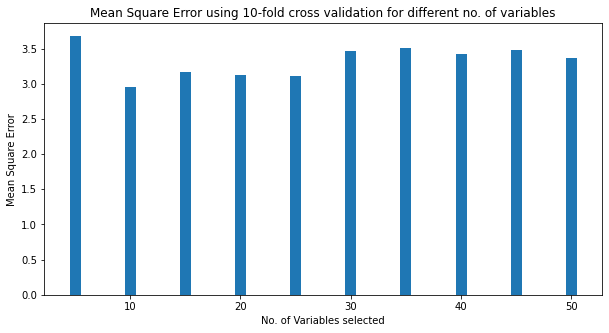

In [47]:
# plot 
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(mse_df['No. of Variables'], mse_df['MSE'],
        width = 1)
 
plt.xlabel("No. of Variables selected")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error using {}-fold cross validation for different no. of variables".format(k))
plt.show()


## Let's train model using ideal no. of variables on entire training data

In [9]:
ideal_vars=10
# Get betas for entire training set based on ideal no. of variables -
betas, val = get_betas(X_train, y_train,k=ideal_vars,time_limit=time_limit)
# Only select first (m+1) entries i.e only beta values and not Z values
m = X_train.shape[1]
betas_test = betas[:(m+1)]

# Predict on Test Set -
y_pred = predict(betas_test, X_test)

# What's the MSE on test set?

mse_test = get_mse(y_test, y_pred)

print("Test MSE: ", mse_test)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


/var/folders/8w/snj_8lln2bz87z87f46_k0t00000gn/T/ipykernel_26897/346389382.py:3: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  betas, val = get_betas(X_train, y_train,k=ideal_vars,time_limit=time_limit)


A:  [[  0.   1.   0. ...   0.   0.   0.]
 [  0.   0.   1. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 100.   0.]
 [  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   1.   1.   1.]]
b:  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 10]
Test MSE:  2.3365439645525274


In [10]:
# Let's also look at the beta co-efficients
betas_test

array([ 0.97252408,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -2.30820726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.51832612, -0.20416201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.55914318,  0.86697336,
        0.        , -1.31191942,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4081653 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.78147489,  0.        ,  0.88738292, -0.28229213,  0.        ,
        0.        ])

# Let's use Lasso with Cross Validation to look at a different way of variable selection -

In [11]:
lassocv = LassoCV(cv=10,random_state=0,normalize=True)
lassocv.fit(X_train, y_train)

/Users/pratikgawli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoCV(cv=10, normalize=True, random_state=0)

In [12]:
# What was the ideal lambda value chosen?

print("Ideal Lambda Value: ",lassocv.alpha_)

Ideal Lambda Value:  0.0057453437864455085


In [13]:
# Lets look at betas

print("Ideal intercept: ", lassocv.intercept_)
print("Ideal betas: \n",lassocv.coef_)

Ideal intercept:  1.0061963544057866
Ideal betas: 
 [-0.         -0.          0.          0.         -0.          0.
 -0.         -0.         -2.11561506  0.         -0.06043079 -0.
 -0.         -0.         -0.41674549 -0.18155256  0.          0.
 -0.          0.          0.         -0.19710223 -1.3655275   0.73510021
 -0.         -1.30018578  0.          0.          0.06390289  0.
 -0.          0.         -0.10737966  0.25392747  0.02138366  0.
  0.          0.         -0.21159473  0.         -0.          0.
  0.          0.01152326  1.53171531 -0.01408773  0.6504778  -0.09757869
  0.          0.        ]


In [14]:
# Different values of alpha that were tested for -
lassocv.alphas_

array([0.1754545 , 0.16362945, 0.15260137, 0.14231655, 0.13272489,
       0.12377968, 0.11543734, 0.10765725, 0.10040151, 0.09363479,
       0.08732412, 0.08143876, 0.07595006, 0.07083128, 0.06605749,
       0.06160544, 0.05745344, 0.05358127, 0.04997007, 0.04660225,
       0.04346142, 0.04053226, 0.03780053, 0.0352529 , 0.03287697,
       0.03066117, 0.02859471, 0.02666752, 0.02487022, 0.02319405,
       0.02163085, 0.020173  , 0.01881341, 0.01754545, 0.01636295,
       0.01526014, 0.01423166, 0.01327249, 0.01237797, 0.01154373,
       0.01076573, 0.01004015, 0.00936348, 0.00873241, 0.00814388,
       0.00759501, 0.00708313, 0.00660575, 0.00616054, 0.00574534,
       0.00535813, 0.00499701, 0.00466023, 0.00434614, 0.00405323,
       0.00378005, 0.00352529, 0.0032877 , 0.00306612, 0.00285947,
       0.00266675, 0.00248702, 0.00231941, 0.00216309, 0.0020173 ,
       0.00188134, 0.00175454, 0.00163629, 0.00152601, 0.00142317,
       0.00132725, 0.0012378 , 0.00115437, 0.00107657, 0.00100

In [15]:
# 10 runs performed for each alpha value. Here are corresponding MSE values for each run -
lassocv.mse_path_

array([[20.94065689, 14.72900042, 15.69614436, 21.84712398, 14.53303302,
        13.57390585, 16.14868239, 26.12535392, 27.64805807, 20.48202264],
       [19.81362409, 14.12578361, 15.10540247, 20.72546759, 13.97998755,
        13.23514889, 15.01621653, 24.59567454, 26.29854625, 19.68280253],
       [18.83271513, 13.61435305, 14.57847589, 19.74377456, 13.52281222,
        12.97388577, 14.02699863, 23.24941401, 25.09285689, 18.98901436],
       [17.97894263, 13.18186273, 13.95455398, 18.76109899, 13.07106216,
        12.65726682, 12.98085158, 21.92118384, 23.83357459, 18.2888446 ],
       [17.12744209, 12.45567265, 13.2745302 , 17.61898849, 12.31319701,
        12.1932973 , 11.89350132, 20.748882  , 22.56731378, 17.40773895],
       [15.79788637, 11.78303847, 12.6762949 , 16.62469836, 11.66068174,
        11.804728  , 10.95162615, 19.71913545, 21.44764948, 16.65244735],
       [14.63625398, 11.20142589, 12.14967289, 15.75907397, 11.09934795,
        11.48072992, 10.13605847, 18.81405938

In [16]:
# Let's predict using test set -
y_pred = lassocv.predict(X_test)

In [17]:
# What is the MSE on test set?
get_mse(y_test,y_pred)

2.3597086675768337

## Visualize

In [18]:
df = pd.DataFrame(columns=['Direct'])
df['Direct'] = pd.Series(betas_test)
df2 = pd.DataFrame(columns=['Lasso'])
inter=pd.Series(lassocv.intercept_)
df2['Lasso'] = pd.concat([inter,pd.Series(lassocv.coef_)])
df3=df2.reset_index()
df3['index'][1:]=df3['index'][1:]+1
final = pd.DataFrame(columns=['Lasso','Direct'])
final['Lasso'] = df3['Lasso']
final['Direct'] = df['Direct']
final=final[(final['Direct'] != 0) | (final['Lasso'] != 0)]

# Let's compare
final

/var/folders/8w/snj_8lln2bz87z87f46_k0t00000gn/T/ipykernel_26897/850090165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['index'][1:]=df3['index'][1:]+1


,Lasso,Direct
0,1.006196,0.972524
9,-2.115615,-2.308207
11,-0.060431,0.000000
15,-0.416745,-0.518326
16,-0.181553,-0.204162
22,-0.197102,0.000000
23,-1.365528,-1.559143
24,0.735100,0.866973
26,-1.300186,-1.311919
29,0.063903,0.000000


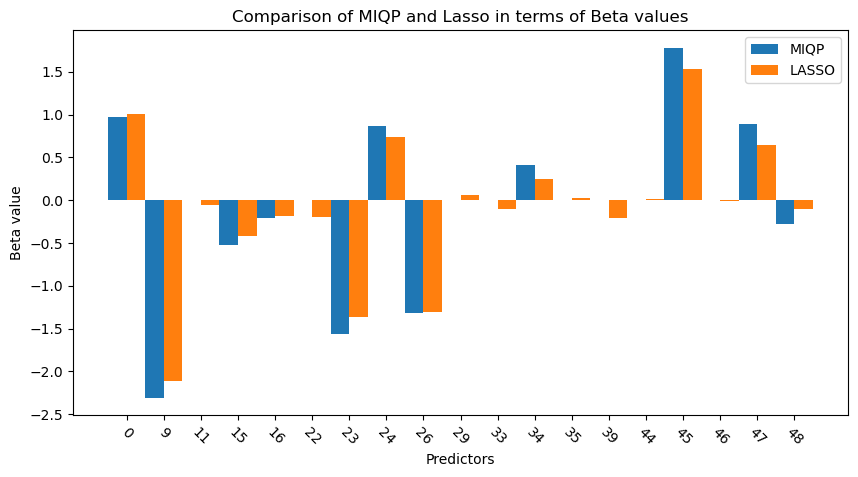

In [19]:
# Let's visualize -
fig = plt.figure(figsize = (10, 5))
width = 0.5
ind = np.arange(len(final))
plt.xticks(ind + width / 2, final.index)
plt.bar(ind, final['Direct'], label='MIQP', width=width)
plt.bar(ind + width, final['Lasso'], label='LASSO', width=width)

plt.xlabel('Predictors')
plt.xticks(rotation = -45)
plt.ylabel('Beta value')
plt.title('Comparison of MIQP and Lasso in terms of Beta values')
plt.legend()
plt.show()